## Исследование умной системы рекомендации товаров в в приложении по доставке продуктов через интерпритацию результатов А/B теста

###  Для проверки работы умной системы рекомендации товаров был проведен АБ-тест, в рамках которого все пользователи приложения были разделены на две группы. Пользователи в группе с номером 0 пользовались старой версией приложения, где нет рекомендации товаров. Пользователи в группе 1 пользовались приложением с новой системой рекомендаций.
### Предполагается, что Умная система рекомендации товаров поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.
### Оценим, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения и правда ли, что новый алгоритм улучшил качество сервиса. Сделаем аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

### ПЛАН РАБОТЫ:

**1. Прочитаем файл и сделаем предобработку данных** 

**2. Посмотрим на следующие метрики:**  
**- Среднее число заказов на каждого пользователя**  
**- Соотношение заказов и отмен в группах**  
**- Среднее число позиций товаров в заказе**  
**- Средний чек**  
**- Retention**

**3. Ответим на вопрос: Смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения и стоит ли включать новую систему рекомендаций на всех пользователей**  

### Данные

**users – история заказов пользователей, в таблице есть информация о том, какие заказы создавали и отменяли пользователи**

**orders – подробная информация о составе заказа, для каждого заказа есть список id тех продуктов, которые были включены в заказ**

**products – подробная информация о продуктах, их название и стоимость**

**Группу с номером 0, в которой пользователи, использующие приложение со старым алгоритмом, будем называть контрольная группа.  
Группу с номером 1, в которой пользователи, использующие приложение с новым алгоритмом для поиска анкет, будем называть тестовая группа** 


## 1. Прочитаем файл и сделаем предобработку данных

In [28]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as st
import pingouin as pg
import numpy as np
import lifelines as lf

In [87]:
# прочитаем наши данные

users = pd.read_csv('ab_users_data.csv')
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

In [88]:
# посмотрим на размер наших df

print(users.shape)
print(orders.shape)
print(products.shape)

(4337, 6)
(4123, 3)
(87, 3)


**размер users (история заказов пользователей) получился больше,   
чем products (подробная информация о составе заказа)  
т.е. на 1 заказ приходится больше строчек истoрии заказов  
я предпологаю, что на один номер заказа приходится несколько строчек 
action (действий с заказами)**

In [89]:
# посмотрим какие статуся заказа могут быть в action

users.action.unique()
# мы видим, что статус может быть заказан, а может быть отменен

array(['create_order', 'cancel_order'], dtype=object)

## 2. Посмотрим на следующие метрики:

**- Соотношение заказов и отмен в группах**  
**- Среднее число заказов на каждого пользователя**  
**- Среднее число позиций товаров в заказе**  
**- Средний чек**  
**- Retention**

### Сравним соотношение заказов и отмен в группах

In [90]:
# вычислим номера заказов (order_id), которые были отменены

order_cancel = users.query('action == "cancel_order"').order_id
order_cancel.head()

8     1258
39    1296
47    1298
54    1308
60    1315
Name: order_id, dtype: int64

In [91]:
# создадим новую колонку is_canctled в users, 
# в которой укажем информацию отменен заказ или нет

# возьмем колонку 'order_id' с помощью метода isin посмотрим попадаются ли order_id
# в количестве тех order_id, заказы которых были отменены
# если попадаются order_id, заказы которых были отменены 
# при методе isin будет TRUE и если не попадаются будет FALSE
# добавим astype(int) и теперь TRUE = 1, FALSE = 0
# если заказ отменен то в is_canctled будет 1

users['is_canctled'] = users['order_id'].isin(order_cancel).astype(int)
users.head()

,user_id,order_id,action,time,date,group,is_canctled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


In [92]:
# так как на отменные заказы в users приходится по две строчки
# то от отменных заказов надо избавится, 
# если заказ был отменен, у нас в колонке есть признак отмены в колонке is_canctled

users = users.query('action == "create_order"')
users.shape

# мы видим, теперь количество заказов в users и orders совпадает

(4123, 7)

In [93]:
# посмотрим на соотношение заказов и отмен в группах

pd.crosstab(users.group, users.is_canctled)

# после кросстабуляции мы видим, что в тестовой группе выросло 
# и количество реально сделанных заказов и отменненых

is_canctled,0,1
group,,
0,1527,82
1,2382,132


In [94]:
# проверим статистическую значимость изменений через Хи квадрат
# используем хи квадрат так как 'is_canctled' это событие

exp, obs, stats = pg.chi2_independence(data = users,
                                     x = 'group',
                                     y = 'is_canctled')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.021274,1.0,0.884034,0.002272,0.052441
1,cressie-read,0.666667,0.021284,1.0,0.884008,0.002272,0.052442
2,log-likelihood,0.000000,0.021304,1.0,0.883954,0.002273,0.052444
3,freeman-tukey,-0.500000,0.021319,1.0,0.883914,0.002274,0.052446
4,mod-log-likelihood,-1.000000,0.021334,1.0,0.883873,0.002275,0.052447
5,neyman,-2.000000,0.021364,1.0,0.883791,0.002276,0.052451


**Получили интересный результат:**

**pval > 0.05, мы не можем говорить, о статистически значимых различиях  
cramer - это коэфициент корреляции - показывает на сколько сильно проявилось данное различие, в нашем случае 0.002 это говорит о том, что количество отмен не изменилось**

**Вывод: увеличение количества отмен, связано с тем, что увеличилось число заказов**

### Сравним среднее число заказов на каждого пользователя

In [95]:
# сгруппируем пользователей по группам и посчитам размер получившихся строк
users.groupby('group', as_index=False).size()

# в тестовой группе (новой версии приложения) количество заказов больше

,group,size
0,0,1609
1,1,2514


In [96]:
# считаем число заказов на каждого юзера
# группируем по группам и номеру юзера
# считаем количество строк

order_por_user = users.groupby(['group', 'user_id'], as_index=False).size()
order_por_user.head()

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1


<Axes: xlabel='size', ylabel='count'>

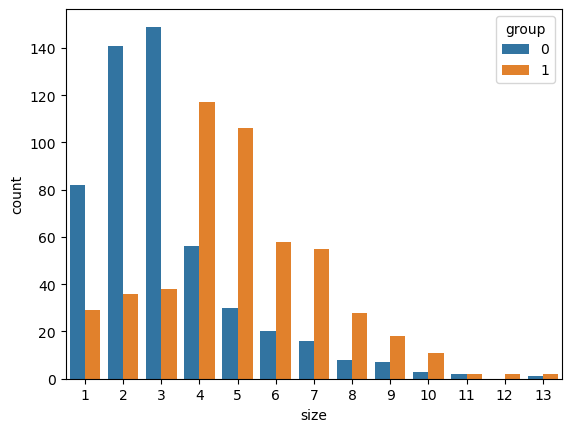

In [97]:
# посмотрим на графике количество заказов на одного пользователя
sns.countplot(data = order_por_user, x = 'size', hue = 'group')

# из графика видно что в контрольной группе смещение в более меньшее кол-во заказов
# в тестовой группе смешение в большее количество заказов на одного пользователя

In [98]:
# сравним наши данные с помощью T-test

pg.ttest(x = order_por_user.query('group == 0')['size'],
        y = order_por_user.query('group == 1')['size'])

# получили статистически значимые различия между нашими группами 
# p-val = 2.907783e-43

# кол-во покупок на 1 пользователя в контрольной группе меньше 
# на [-2.14, -1.63], в среднем 2 заказа на пользователя

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.485157,988.435475,two-sided,2.907783e-43,"[-2.14, -1.63]",0.910119,7.663e+39,1.0


**получили статистически значимые различия между нашими группами p-val = 2.907783e-43**

**Вывод: кол-во покупок на 1 пользователя в тестовой группе больше на [-2.14, -1.63], в среднем 2 заказа на пользователя**

### Сравним среднее число позиций товаров в заказе

In [99]:
# обьедим два df users и orders
# из таблицы users нам нужны только столбцы  ['user_id', 'order_id', 'group']

ord_content = users[['user_id', 'order_id', 'group']].merge(orders)
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [100]:
# теперь нам надо преобразовать колонку product_ids

# strip('{}') убираем фигурные скобки
# str.split(', ') и делаем полноценный список
# далее используем метод explode на этом списке

ord_content['product_ids'] = ord_content.product_ids.str.strip('{}').str.split(', ')
ord_content_exp1 = ord_content.explode('product_ids')

ord_content_exp1.head()
# теперь у нас заказы разбились на несколько частей 
# количество частей соответствует количеству product_ids в каждом заказе

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56


In [101]:
# сгруппируем по order_id и group и посчитаем количество product_ids
# в каждом заказе

item_per_order = ord_content_exp1.groupby(['group', 'order_id'], as_index=False).size()
item_per_order.head()

,group,order_id,size
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4


<Axes: xlabel='size', ylabel='count'>

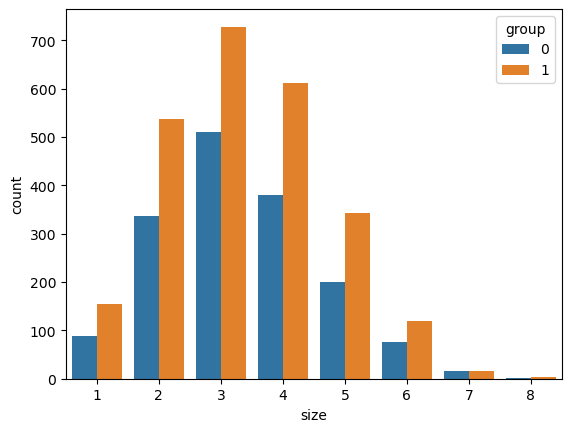

In [102]:
# посмотрим на графике число позиций в заказе

sns.countplot(data = item_per_order, x = 'size', hue = 'group')

# очень похожие распределения
# столбики повыше в тестовой группе
# так как количество заказов стало больше

In [104]:
# проверим на сколько статистически значимы наши различия 

pg.ttest(x = item_per_order.query('group == 0')['size'],
        y = item_per_order.query('group == 1')['size'])

# мы не получили статистически значимые различия между нашими группами 
# p-val = 0.889809

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138556,3469.224056,two-sided,0.889809,"[-0.09, 0.07]",0.004407,0.036,0.052185


**При сравнении среднего количества позиций товаров в заказе мы не получили статистически значимые различия между нашими группами p-val = 0.889809    
Вывод: новая система рекомендаций не повлияла на количество позиций товаров в заказе**

### Сравним средний чек в тестовой и контрольной группе

In [105]:
# используем наш готовый df ord_content_exp1

ord_content_exp1.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56


In [106]:
# проверим типы колонок

ord_content_exp1.dtypes

user_id           int64
order_id          int64
group             int64
creation_time    object
product_ids      object
dtype: object

In [107]:
# новая колонка product_ids оказалась object, конвертируем ее на int64

ord_content_exp1.product_ids = ord_content_exp1.product_ids.astype(np.int64)

In [108]:
# проверим, что все получилось

ord_content_exp1.dtypes

user_id           int64
order_id          int64
group             int64
creation_time    object
product_ids       int64
dtype: object

In [109]:
# обьединим два df ord_content_exp1 и products
# будем обьединять по колонкам 'product_ids' в ord_content_exp1 
# и 'product_id' в products

ord_prices = ord_content_exp1.merge(products, left_on = 'product_ids', right_on='product_id')
ord_prices.sort_values('order_id').head()

,user_id,order_id,group,creation_time,product_ids,product_id,name,price
0,964,1255,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0
371,964,1255,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4
205,964,1255,0,2022-08-26 00:00:19.000000,53,53,мука,78.3
118,964,1255,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0
837,965,1256,1,2022-08-26 00:02:21.000000,76,76,чай черный в пакетиках,55.5


In [110]:
# посчитаем стоимость каждого заказа
# для этого сгруппируем по order_id и проссумируем price

value_per_order = ord_prices.groupby(['group', 'order_id'], as_index = False).price.sum()
value_per_order.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6


<Axes: xlabel='price', ylabel='Count'>

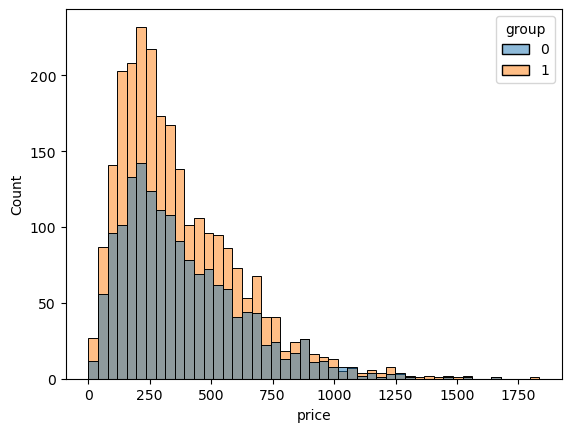

In [111]:
# посмотрим на графике

sns.histplot(data = value_per_order, x = 'price', hue = 'group')

# видим что в стоимости заказа различий нет
# только в количестве заказов

In [112]:
# проверим на сколько статистически значимы наши различия с помощью T-test

pg.ttest(x = value_per_order.query('group == 0')['price'],
        y = value_per_order.query('group == 1')['price'])

# мы не получили статистически значимые различия между нашими группами 
# p-val = 0.13803

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.483514,3441.720793,two-sided,0.13803,"[-3.75, 27.08]",0.047301,0.108,0.316351


**При сравнении среднего чека в тестовой и контрольной группе мы не получили статистически значимые различия между нашими группами p-val = 0.13803**

Вывод: новая система рекомендаций не повлияла на средний чек**

### Сделем расчет Retention и посмотрим насколько долго клиенты остаются в нашем приложении и пользуются нашими услугами в тестовой и в контрольной группе

In [113]:
# для расчета Retention будем использовать df ord_content

ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


In [114]:
# проверим типы колонок,тк будем работать с датами в creation_time должен быть тип datetime

ord_content.dtypes

user_id           int64
order_id          int64
group             int64
creation_time    object
product_ids      object
dtype: object

In [115]:
#creation_time - object, конвертируем ее в datetime

ord_content.creation_time = pd.to_datetime(ord_content.creation_time)

In [116]:
# проверим, что все получилось

ord_content.dtypes

user_id                   int64
order_id                  int64
group                     int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

In [119]:
# посмотрим какие есть характеристики у нашего времени

ord_content.creation_time.describe()

# самое интересное это макс и мин время

count                             4123
mean     2022-08-30 14:45:06.142372096
min                2022-08-26 00:00:19
25%         2022-08-26 20:14:15.500000
50%                2022-08-29 12:37:43
75%         2022-09-02 20:46:49.500000
max                2022-09-08 23:41:24
Name: creation_time, dtype: object

In [120]:
# вычтем из max min и получим длинну нашего эксперимента

ord_content.creation_time.max() - ord_content.creation_time.min()

# эксперимент длился две недели

Timedelta('13 days 23:41:05')

In [121]:
# выявим время первого и последнего заказа для каждого клиента

retention = ord_content.groupby(['user_id', 'group'], as_index=False)\
    .agg(first_order = ('creation_time', 'min'), last_order = ('creation_time', 'max'))

retention.head()

,user_id,group,first_order,last_order
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34


In [122]:
# посмотрим как распределилсь характеристики первого и последнего заказа

(retention.last_order - retention.first_order).describe()

# mean =  6 days 23:27:21 - в среднем пользователи использовали приложение неделю
# min =   0 days - кто-то сделали только один заказ (первый заказ был и последним)
# max =   13 days 22:36:14 -  кто то пользовался все две недели

count                         1017
mean     6 days 23:27:21.923303834
std      4 days 06:43:22.480610835
min                0 days 00:00:00
25%                3 days 11:27:14
50%                7 days 15:39:20
75%               10 days 13:37:01
max               13 days 22:36:14
dtype: object

In [126]:
# посчитаем время жизни для каждого пользователя

# dt.total_seconds - выводит разницу между первым и последним заказом в секундах
# (3600*24) - далее секунды конвертируем в дни

retention['lifetime'] = (retention.last_order - retention.first_order).dt.total_seconds()/(3600*24)
retention.head()

,user_id,group,first_order,last_order,lifetime
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600


In [127]:
# проверим, когда пользователи сделали первый заказ

retention.first_order.dt.date.unique()
# все пользователи сделали первый заказ 2022, 8, 26
# все пользователи из одной кагорты

array([datetime.date(2022, 8, 26)], dtype=object)

In [128]:
# сделаем переменную оттока
# когда мы считаем что наш клиент нас покинул?
# pd.Timedelta ('7d') - через 7 дней
# если клиент не делал заказ 7 дней, значит он от нас ушел

retention['churn'] = ((ord_content.creation_time.max() - retention.last_order) > pd.Timedelta('7d')).astype(int)
retention.head()

# churn показывает ушел клиент от нас или нет
# 1 = ушел

,user_id,group,first_order,last_order,lifetime,churn
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481,1
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072,0
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000,1
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975,1
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600,1


<Axes: xlabel='lifetime', ylabel='Count'>

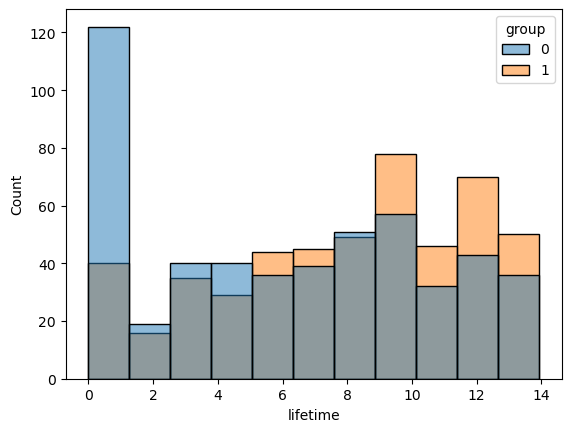

In [129]:
# посмотрим на графике

sns.histplot(data = retention, x= 'lifetime', hue='group')

# видим что lifetime распределен примерно равномерно
# единственно в контрольной группе много тех кто сделал 1 заказ

In [131]:
# посмотрим на отток по группам

pd.crosstab(retention.group, retention.churn)
# видим что в тестовой группе отток меньше чем в контрольной

churn,0,1
group,,
0,252,263
1,332,170


In [132]:
# проверим статистическую значимость изменений через Хи квадрат
# используем Хи квадрат, так как 'churn' это событие

exp, obs, stats = pg.chi2_independence(data = retention,
                                     x = 'group',
                                     y = 'churn')

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,30.072727,1.0,4.161428e-08,0.171959,0.999787
1,cressie-read,0.666667,30.113482,1.0,4.074885e-08,0.172076,0.999790
2,log-likelihood,0.000000,30.250438,1.0,3.797055e-08,0.172467,0.999800
3,freeman-tukey,-0.500000,30.402505,1.0,3.510745e-08,0.172900,0.999810
4,mod-log-likelihood,-1.000000,30.597845,1.0,3.174461e-08,0.173454,0.999823
5,neyman,-2.000000,31.122750,1.0,2.422158e-08,0.174936,0.999852


**При сравнении оттока клиентов, мы можем говорить, о статистически значимых различиях pval< 0.05  
cramer - это коэфициент корреляции - показывает на сколько сильно проявилось данное различие, в нашем случае 0.17, это говорит о том, что количество уходов клиентов изменилось**

**Вывод: нас статистически значимо не покидают пользователи, которые используют новую систему рекомендации товаров**


## 3. Ответим на вопрос: Смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения и стоит ли включать новую систему рекомендаций на всех пользователей

**Количество покупок на одного пользователя  изменилось, в тестовой группе в среднем на 2 заказа на пользователя больше и мы получили статистически значимые различия в этой метрике,   
делаю вывод: Новая система рекомендаций стала удобнее для пользователей и они стали чаще делать покупки в приложении, тем самым увеличивая выручку и прибыль приложения доставки**

**При проверке метрики Соотношение заказов и отмен в группах, мы не получили статистически значимых различий 
делаю вывод: Увеличение отмен в тестовой группе связано с увеличением числа заказов.**

**Retention в тестовой группе выше, отток клиентов в тестовой группе меньше, здесь мы также получили статистически значимые различия,  
делаю вывод: Новая система рекомендаций удерживает больше клиентов, и как следствие увеличивает обьем продаж**

**при проверке таких метрик как:**  
**- Среднее число позиций товаров в заказе**  
**- Средний чек  
мы не получили статистически значимых различий, это говорит о том, что не смотря на увеличение числа заказов и удержание клиентов, новая система рекомендаций не выполняет свою задачу на 100 % и стоит обратить внимание на улучшение этих метрик**

## МОЙ ОТВЕТ: Смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения и стоит ли включать новую систему рекомендаций на всех пользователей

### В целом считаю эксперимент успешным, и вот почему:
**Умная система рекомендации товаров предназначена для выстраивания долгосрочных отношений с пользователем и повышения продаж. В нашем случае пользователи в тестовой группе стали делать покупки чаще, значит Новая система рекомендации справилась с этой задачей, и все же в ближайшем будущем я бы рассмотрела улучшение системы рекомендации, так как в таких важных метриках как средний чек и среднее число позиций товаров в заказе мы не получили статистически значимых изменений.**

### Рекомендую включить новую систему рекомендаций на всех пользователей.